In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 27 06:35:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
!pip install tensorflow==2.15.0
!pip install keras==2.13.1
!pip install --upgrade google-cloud-storage
!pip install opencv-python
!pip install tensorflow-addons
!pip install keras-tuner
!pip install seaborn
!pip install scikit-image
!pip install tensorflow timm pydicom
!pip install onnx-tf
!pip install vit-keras
!pip install lime
!pip install grad-cam
!pip install tf-keras-vis

  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.13.1 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [6]:
import os
import random
import pandas as pd
import pydicom
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from skimage.transform import resize
import tensorflow as tf
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer
import matplotlib.patches as patches
from lime.wrappers.scikit_image import SegmentationAlgorithm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from lime import lime_image
from tensorflow.keras.layers import (Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,)
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [7]:
import tensorflow as tf
import pandas as pd
from google.cloud import storage
import io
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Initialize a Google Cloud Storage client
storage_client = storage.Client()

# Define your bucket name and file path in the bucket
bucket_name = 'xai-model'
blob_path = 'AD_ALL_1000.csv'

# Get the bucket and create a blob object
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(blob_path)

# Create a file-like object using the blob
file_like_object = io.BytesIO()
blob.download_to_file(file_like_object)
file_like_object.seek(0)

# Read the file into a pandas DataFrame
df = pd.read_csv(file_like_object)

# Display the first few rows of the DataFrame
df.head(100)

Num GPUs Available:  1


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I1221058,002_S_0413,CN,F,90,y2,MRI,Sagittal 3D FLAIR,Original,8/27/2019,DCM,9/11/2023
1,I1221059,002_S_0413,CN,F,90,y2,MRI,HighResHippocampus,Original,8/27/2019,DCM,9/11/2023
2,I1221060,002_S_0413,CN,F,90,y2,MRI,Axial 3TE T2 STAR,Original,8/27/2019,DCM,9/11/2023
3,I1221061,002_S_0413,CN,F,90,y2,MRI,Axial 3TE T2 STAR,Original,8/27/2019,DCM,9/11/2023
4,I1221062,002_S_0413,CN,F,90,y2,MRI,Field Mapping,Original,8/27/2019,DCM,9/11/2023
...,...,...,...,...,...,...,...,...,...,...,...,...
95,I274152,002_S_1155,MCI,M,63,v06,MRI,Axial T2-FLAIR,Original,12/22/2011,DCM,9/11/2023
96,I274154,002_S_1155,MCI,M,63,v06,MRI,MPRAGE,Original,12/22/2011,DCM,9/11/2023
97,I303066,002_S_0295,CN,M,91,v11,MRI,MPRAGE,Original,5/10/2012,DCM,9/11/2023
98,I303067,002_S_0295,CN,M,91,v11,MRI,MPRAGE SENSE2,Original,5/10/2012,DCM,9/11/2023


In [8]:
import tensorflow as tf
import pandas as pd
from google.cloud import storage
import io
import cv2
import pydicom
from sklearn.model_selection import train_test_split

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Initialize a Google Cloud Storage client
storage_client = storage.Client()

# Define your bucket name and file path in the bucket
bucket_name = 'xai-model'
blob_path = 'AD_ALL_1000.csv'

# Get the bucket and create a blob object
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(blob_path)

# Create a file-like object using the blob
file_like_object = io.BytesIO()
blob.download_to_file(file_like_object)
file_like_object.seek(0)

# Read the file into a pandas DataFrame
df = pd.read_csv(file_like_object)

# Display the first few rows of the DataFrame
df.head(100)

# Function to list all DICOM files from multiple subfolders
def list_dicom_files(bucket_name, prefix=''):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    # Use a delimiter to ensure recursive listing of all files inside subfolders
    blobs = bucket.list_blobs(prefix=prefix)

    # Collect all .dcm files
    dicom_files = []
    for blob in blobs:
        if blob.name.endswith('.dcm'):
            dicom_files.append(f"gs://{bucket_name}/{blob.name}")

    return dicom_files

# Listing DICOM image paths
dicom_prefix = 'ADNI_1000'  # Ensure this prefix points to the root of your subfolder structure
image_paths = list_dicom_files(bucket_name, dicom_prefix)
print(f"Total number of DICOM image paths: {len(image_paths)}")

# Check if any DICOM files were found
if len(image_paths) == 0:
    raise ValueError(f"No DICOM files found in bucket '{bucket_name}' with prefix '{dicom_prefix}'. Please check the bucket contents and prefix.")

# Define model configuration
BATCH_SIZE = 128
input_shape = (224, 224, 3)
num_classes = 3  # CN, MCI, AD
class_names = ['CN', 'MCI', 'AD']

# Function to convert DICOM to RGB
def dicom_to_rgb(dicom_blob):
    dcm_data = io.BytesIO()
    dicom_blob.download_to_file(dcm_data)
    dcm_data.seek(0)
    dcm = pydicom.dcmread(dcm_data)
    pixel_array = cv2.normalize(dcm.pixel_array, None, alpha=0, beta=255,
                                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return cv2.cvtColor(pixel_array, cv2.COLOR_GRAY2RGB)

# Function to convert DICOM to RGB and preprocess image
def preprocess_image(dicom_gcs_uri):
    dicom_gcs_uri = dicom_gcs_uri.numpy().decode('utf-8')
    bucket_name, blob_path = dicom_gcs_uri.split("gs://", 1)[1].split("/", 1)
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(blob_path)
    img = dicom_to_rgb(blob)

    # Resize the image to a smaller size for efficiency
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

    return img / 255.0

# Function to load and process image
def load_and_process_image(img_path, label):
    img = tf.py_function(func=preprocess_image, inp=[img_path], Tout=tf.float32)
    img.set_shape((224, 224, 3))  # Ensure consistent shape
    return img, label

# Function to get label from DataFrame with debugging
def get_label(img_path, df):
    filename = img_path.split('/')[-1]  # Extract the file name from the full path
    filename_parts = filename.split('_')
    subject = '_'.join(filename_parts[1:4])  # Adjust based on filename structure
    print(f"Extracted subject: {subject} from filename: {filename}")

    # Filter the DataFrame to find the matching subject
    filtered_df = df[df['Subject'] == subject]
    if filtered_df.empty:
        print(f"No match found for subject: {subject}")
        return -1  # Return -1 if no match is found

    label = filtered_df['Group'].values[0]
    print(f"Found label: {label} for subject: {subject}")

    return {'CN': 0, 'MCI': 1, 'AD': 2}.get(label, -1)

# Generate labels for all image paths
labels = [get_label(path, df) for path in image_paths]

# Check if labels are all -1
if all(label == -1 for label in labels):
    raise ValueError("All labels are invalid (-1). Check the get_label function and the DataFrame.")

# Filter out images with labels that were not found (-1)
filtered_data = [(path, label) for path, label in zip(image_paths, labels) if label != -1]

# Check if any valid data was found
if len(filtered_data) == 0:
    raise ValueError("No valid labels found after filtering. Please check your dataset.")

# Unpack filtered data
filtered_image_paths, filtered_labels = zip(*filtered_data)

# Convert from tuples to lists
filtered_image_paths = list(filtered_image_paths)
filtered_labels = list(filtered_labels)

# Split dataset into training, validation, and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    filtered_image_paths,
    filtered_labels,
    test_size=0.2,
    random_state=42
)

val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    test_image_paths,
    test_labels,
    test_size=0.5,
    random_state=42
)

# Function to create TensorFlow dataset
def create_dataset(image_paths, labels, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Reducing shuffle buffer size for memory efficiency
    shuffle_buffer_size = min(len(image_paths), 5000)  # Adjust based on your system's RAM

    return (dataset
            .shuffle(buffer_size=shuffle_buffer_size)
            .batch(batch_size)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

def preprocess_image_only(img_path):
    img = tf.py_function(func=preprocess_image, inp=[img_path], Tout=tf.float32)
    img.set_shape((224, 224, 3))  # Ensure the consistent shape for TensorFlow
    return img

def create_prediction_dataset(image_paths, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image_only, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_image_ds = create_prediction_dataset(train_image_paths, BATCH_SIZE)
val_image_ds = create_prediction_dataset(val_image_paths, BATCH_SIZE)
test_image_ds = create_prediction_dataset(test_image_paths, BATCH_SIZE)

train_label_ds = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)
val_label_ds = tf.data.Dataset.from_tensor_slices(val_labels).batch(BATCH_SIZE)
test_label_ds = tf.data.Dataset.from_tensor_slices(test_labels).batch(BATCH_SIZE)

def count_dataset_elements(dataset):
    # This function counts the number of elements in a batched dataset.
    count = 0
    for batch in dataset:
        count += len(batch)  # Assuming batch is a tuple of (images, labels) or just images
    return count

# Calculate and print the number of images in each dataset
train_image_count = count_dataset_elements(train_image_ds)
val_image_count = count_dataset_elements(val_image_ds)
test_image_count = count_dataset_elements(test_image_ds)

# Calculate and print the number of labels in each dataset
train_label_count = count_dataset_elements(train_label_ds)
val_label_count = count_dataset_elements(val_label_ds)
test_label_count = count_dataset_elements(test_label_ds)

print(f"Number of images in training dataset: {train_image_count}")
print(f"Number of images in validation dataset: {val_image_count}")
print(f"Number of images in testing dataset: {test_image_count}")

print(f"Number of labels in training dataset: {train_label_count}")
print(f"Number of labels in validation dataset: {val_label_count}")
print(f"Number of labels in testing dataset: {test_label_count}")


Streaming output truncated to the last 5000 lines.
Extracted subject: 002_S_1155 from filename: ADNI_002_S_1155_MR_B1-Calibration_Body__br_raw_20080821235446763_27_S55660_I116606.dcm
Found label: MCI for subject: 002_S_1155
Extracted subject: 002_S_1155 from filename: ADNI_002_S_1155_MR_B1-Calibration_Body__br_raw_20080821235446918_28_S55660_I116606.dcm
Found label: MCI for subject: 002_S_1155
Extracted subject: 002_S_1155 from filename: ADNI_002_S_1155_MR_B1-Calibration_Body__br_raw_20080821235447080_29_S55660_I116606.dcm
Found label: MCI for subject: 002_S_1155
Extracted subject: 002_S_1155 from filename: ADNI_002_S_1155_MR_B1-Calibration_Body__br_raw_20080821235447234_3_S55660_I116606.dcm
Found label: MCI for subject: 002_S_1155
Extracted subject: 002_S_1155 from filename: ADNI_002_S_1155_MR_B1-Calibration_Body__br_raw_20080821235447527_30_S55660_I116606.dcm
Found label: MCI for subject: 002_S_1155
Extracted subject: 002_S_1155 from filename: ADNI_002_S_1155_MR_B1-Calibration_Body__

#EfficientNet

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Initialize the MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

def efficient_net_custom_classifier(input_shape, num_classes):
    # EfficientNetB0 model with ImageNet weights, without the top classification layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(base_model.output)

    # Adding dense layers with BatchNormalization and Dropout
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer with softmax activation for multi-class classification
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model's layers except the last 20
    for layer in base_model.layers[:-20]:  # Adjust the number of layers to freeze/unfreeze
        layer.trainable = False

    return model

# Build and compile the model within the strategy's scope
with strategy.scope():
    model = efficient_net_custom_classifier(input_shape=(224, 224, 3), num_classes=3)

    # Set the learning rate for the Adam optimizer
    learning_rate = 1e-4  # Adjust the learning rate based on your needs
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the optimizer and sparse categorical crossentropy
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint callback
    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/XAI in Computer Vision /CHECKPOINTS/Checkpoint_EfficientNet3_model.weights.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

# Zip the images and labels to create complete datasets for training, validation, and testing
train_dataset = tf.data.Dataset.zip((train_image_ds, train_label_ds))
val_dataset = tf.data.Dataset.zip((val_image_ds, val_label_ds))
test_dataset = tf.data.Dataset.zip((test_image_ds, test_label_ds))

# Prefetch datasets
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=1000,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback, model_checkpoint_callback],
    verbose=1
)

# Evaluate the model
score = model.evaluate(test_dataset, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


Epoch 1/1000
138/138 [==============================] - 3616s 26s/step - loss: 1.6101 - accuracy: 0.3389 - val_loss: 1.1089 - val_accuracy: 0.4140
Epoch 2/1000
138/138 [==============================] - 3511s 25s/step - loss: 1.4465 - accuracy: 0.3503 - val_loss: 1.0515 - val_accuracy: 0.4140
Epoch 3/1000
138/138 [==============================] - 3461s 25s/step - loss: 1.3658 - accuracy: 0.3629 - val_loss: 1.0628 - val_accuracy: 0.4140
Epoch 4/1000
138/138 [==============================] - 3332s 24s/step - loss: 1.3198 - accuracy: 0.3699 - val_loss: 1.0579 - val_accuracy: 0.4140
Epoch 5/1000
138/138 [==============================] - 3570s 26s/step - loss: 1.2782 - accuracy: 0.3783 - val_loss: 1.0462 - val_accuracy: 0.4140
Epoch 6/1000
138/138 [==============================] - 3207s 23s/step - loss: 1.2455 - accuracy: 0.3850 - val_loss: 1.0529 - val_accuracy: 0.4140
Epoch 7/1000
138/138 [==============================] - 3407s 25s/step - loss: 1.2275 - accuracy: 0.3871 - val_loss: 1

In [11]:
# Print the model summary to identify the correct layer name
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

4/4 [==============================] - 2s 17ms/step


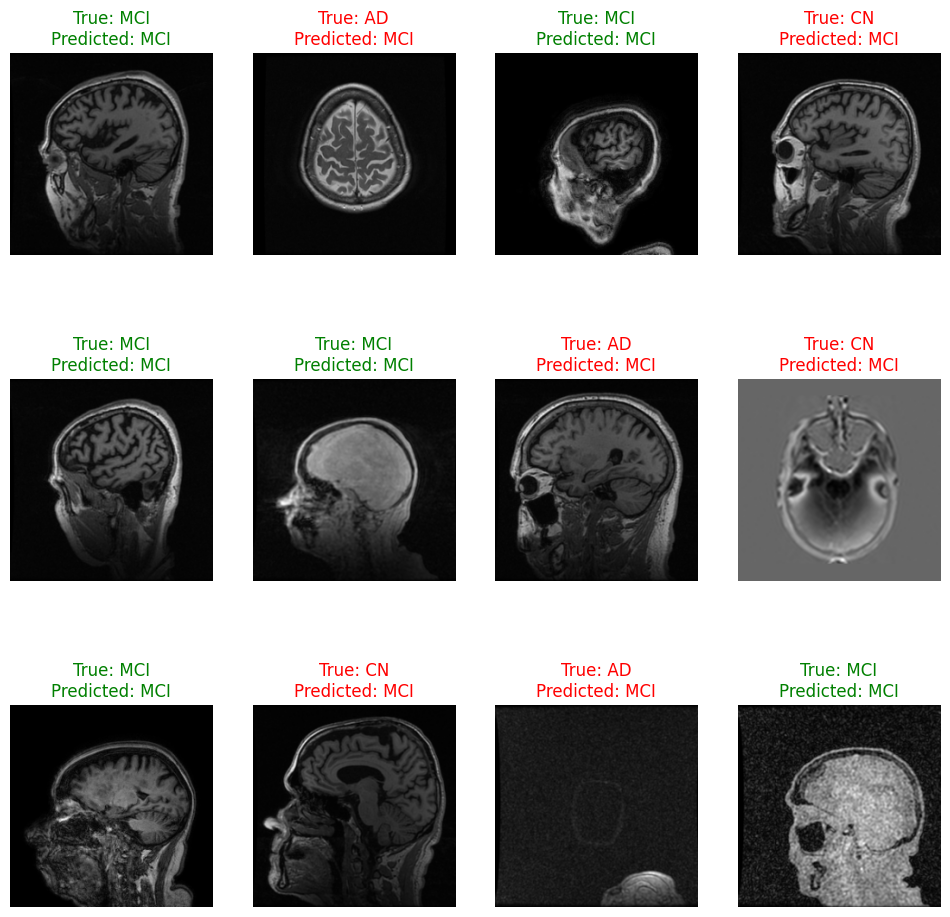

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def show_predicted_images(images, labels, predictions):
    plt.figure(figsize=(12, 12))
    for i in range(min(12, len(images))):  # Display the first 12 images
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        true_label = class_names[labels[i]]
        predicted_label = class_names[predictions[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')
    plt.show()

# Assuming model and test_dataset are defined and loaded
for test_images, test_labels in test_dataset.take(1):  # Take one batch from the test dataset
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    show_predicted_images(test_images.numpy(), test_labels.numpy(), predicted_labels)

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_dataset and your model are defined and loaded
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

          CN       0.00      0.00      0.00       876
         MCI       0.41      1.00      0.58       892
          AD       0.00      0.00      0.00       430

    accuracy                           0.41      2198
   macro avg       0.14      0.33      0.19      2198
weighted avg       0.16      0.41      0.23      2198



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


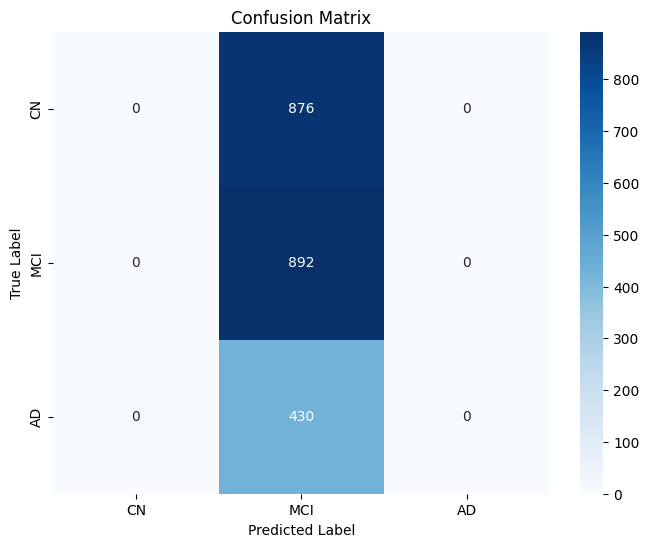

In [14]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
model.save('/content/drive/MyDrive/XAI in Computer Vision /MODEL-S/EFF3_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model.save('/content/drive/MyDrive/XAI in Computer Vision /MODEL-S/EFF3_model.keras')